# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/ryan/.virtualenvs/metnum-tp2/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/ryan/UBA/METODOS/metnum-tp2
-- Configuring done
-- Generating done
-- Build files have been written to: /home/ryan/UBA/METODOS/metnum-tp2/build
Scan

In [2]:
import dill
knn_df_file = open("data/knn_df", "rb")
try:
    data = knn_df_file.read()
    knn_df = dill.loads(data)
finally:
    knn_df_file.close()
    
pca_df_file = open("data/pca_df", "rb")
try:
    data = pca_df_file.read()
    pca_df = dill.loads(data)
finally:
    pca_df_file.close()

In [4]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum
from commons import *


/home/ryan/UBA/METODOS/metnum-tp2/notebooks
Python 3.8.5


## Explorando los datos

In [7]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [8]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

### Conjunto de development

In [10]:
import random
from functools import reduce

limit = X.shape[0]
order = list(range(0,limit))
random.shuffle(order)

X_shuffled, y_shuffled = [], [] 

for i in order:
    X_shuffled += [X[i]]
    y_shuffled += [y[i]]

K_folds = 5
folds_size = int(limit/K_folds)

X_folds, y_folds = [], []

for i in range(0,K_folds):
    l, h = i * folds_size , (i+1) * folds_size
    X_folds += [X_shuffled[l:h]]
    y_folds += [y_shuffled[l:h]]
    
def getKFold(X_folds,y_folds, K):
    X_train_folds = X_folds[0:K] + X_folds[K+1:len(X_folds)]
    y_train_folds = y_folds[0:K] + y_folds[K+1:len(y_folds)]
    train = (reduce(lambda a,b : a+b,X_train_folds), reduce(lambda a,b : a+b,y_train_folds))
    val = (X_folds[K], y_folds[K])
    return (train,val)

test_train, test_val = getKFold(X_folds,y_folds,4)

X_train, y_train = test_train
X_val , y_val = test_val


assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [11]:
%%time
from sklearn.metrics import accuracy_score

preds = [[], [], [], [], []]
k=0

for l in [500,1000,5000,10000, 20000]:
    test_l = int(l*0.2)

    pca = metnum.PCA(28)
    pca.fit(X_train[:l])

    Y_train = pca.transform(X_train[:l])
    Y_test = pca.transform(X_val[:test_l])

    for i in [1, 5, 10, 30, 50, 100, 500]:
        clf = metnum.KNNClassifier(i)
        clf.fit(Y_train, y_train[:l])
        y_pred = clf.predict(Y_test)

        acc = accuracy_score(y_val[:test_l], y_pred)
        preds[k].append(acc)
        
    k += 1
    #print(f"For training size {l} and test size {test_l}")
    #print("Accuracy: {}".format(acc))
    
print(preds)

[[0.85, 0.84, 0.86, 0.76, 0.73, 0.6, 0.09], [0.94, 0.915, 0.925, 0.87, 0.815, 0.75, 0.41], [0.932, 0.949, 0.954, 0.939, 0.931, 0.909, 0.808], [0.9495, 0.957, 0.956, 0.9515, 0.9405, 0.9285, 0.8675], [0.96825, 0.969, 0.9665, 0.958, 0.9545, 0.94425, 0.9005]]
CPU times: user 1min 31s, sys: 296 ms, total: 1min 31s
Wall time: 1min 31s


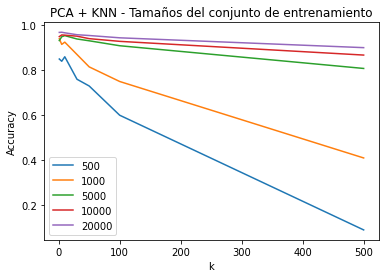

In [12]:
# Plot PCA + KNN - Tamaños del conjunto de entrenamiento vs k
size = ["500","1000","5000","10000", "20000"]
for i in range(0, 5):
    plt.plot([1, 5, 10, 30, 50, 100, 500], preds[i], label=size[i])
plt.title('PCA + KNN - Tamaños del conjunto de entrenamiento')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('k')
plt.show()